In [1]:
from numpy.random import seed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import itertools
import tensorflow
import tensorflow.keras
from tensorflow.keras.applications import ResNet152, Xception,VGG16,EfficientNetB4
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from scipy.ndimage.filters import sobel
from keras.layers import BatchNormalization
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
np.random.seed(123)

In [2]:
dataset = '../input/weather-dataset/dataset/'
labels = sorted(os.listdir(dataset))
image = []
label = []
for i in labels:
    st = dataset + i
    for j in os.listdir(st):
        stg = st +"/"+ j
        label.append(i)
        image.append(stg)
        
WeatherData = pd.DataFrame({'label':label, 'path' : image}, columns = ['label', 'path'])

In [3]:
WeatherData['image'] = WeatherData['path'].map(lambda x: np.asarray(Image.open(x).resize((100,100), Image.LANCZOS).convert('RGB')))

In [4]:
WeatherData = WeatherData.sample(frac=1, random_state=42)

In [6]:
Features = np.stack(WeatherData['image'].values)
Target = WeatherData['label']

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(Features, Target, test_size=0.3,random_state=666)
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [12]:
label_encoder = LabelEncoder()
y_train_o = label_encoder.fit_transform(y_train_o)
y_test_o = label_encoder.transform(y_test_o)
y_train = to_categorical(y_train_o, num_classes = 11)
y_test = to_categorical(y_test_o, num_classes = 11)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 999, stratify=y_train)

In [13]:
input_shape = (100, 100, 3)
num_classes = 11

In [14]:
input_shape = (100, 100, 3)
num_classes = 11
x_train = x_train.reshape(x_train.shape[0], *(100, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 100, 3))

In [17]:
res_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in res_model.layers:
    layer.trainable = False

x = Flatten()(res_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=res_model.input, outputs=x)

In [19]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=4, verbose=1, factor=0.5, min_lr=0.00001)

#Data Generation
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train,y_train, batch_size=128),
                              epochs = 50, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 128
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
30/30 [==============================] - 15s 365ms/step - loss: 5.4292 - accuracy: 0.2165 - val_loss: 2.1412 - val_accuracy: 0.3278 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 10s 334ms/step - loss: 1.8785 - accuracy: 0.3503 - val_loss: 1.7354 - val_accuracy: 0.3684 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 10s 343ms/step - loss: 1.8279 - accuracy: 0.3729 - val_loss: 1.6891 - val_accuracy: 0.3985 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - 10s 333ms/step - loss: 1.7102 - accuracy: 0.4015 - val_loss: 1.5722 - val_accuracy: 0.4662 - lr: 0.0010
Epoch 5/50
30/30 [==============================] - 9s 314ms/step - loss: 1.6041 - accuracy: 0.4308 - val_loss: 1.5025 - val_accuracy: 0.4787 - lr: 0.0010
Epoch 6/50
30/30 [==============================] - 10s 319ms/step - loss: 1.5204 - accuracy: 0.4615 - val_loss: 1.5570 - val_accuracy: 0.4370 - lr: 0.0010
Epoch 7/50
30/30 [==============================] - 11s 358ms/ste

In [20]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)
print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

Training: accuracy = 0.582249
Validation: accuracy = 0.532778
Test: accuracy = 0.559495


65/65 [==============================] - 1s 19ms/step


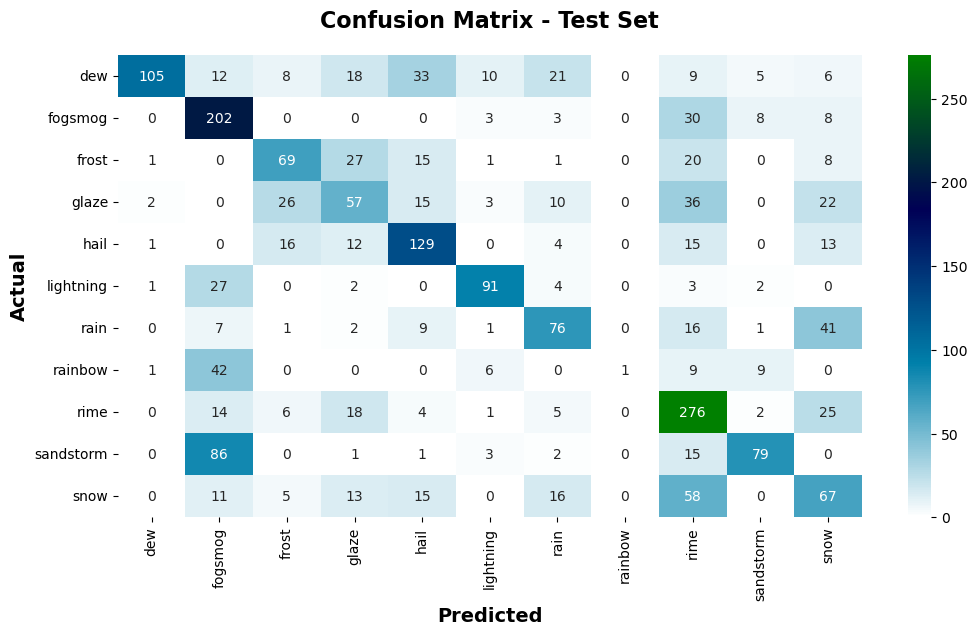

In [22]:
predictions = np.array(list(map(lambda x: np.argmax(x), model.predict(x_test))))
categories = label_encoder.classes_
CM = confusion_matrix(np.argmax(y_test, axis=1), predictions)
CMatrix = pd.DataFrame(CM, columns = categories, index = categories)
plt.figure(figsize=(12, 6)) 
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g',vmax = max(np.diagonal(CM)),cmap = 'ocean_r') 
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold') 
ax.set_xticklabels(ax.get_xticklabels(),rotation =90); 
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
plt.show()

In [23]:
from tensorflow.keras.applications import InceptionV3

inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in inception_model.layers:
    layer.trainable = False

x = Flatten()(inception_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inception_model.input, outputs=x)

87910968/87910968 [==============================] - 1s 0us/step


In [24]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=4, verbose=1, factor=0.5, min_lr=0.00001)

#Data Generation
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train,y_train, batch_size=128),
                              epochs = 50, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 128
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
30/30 [==============================] - 17s 380ms/step - loss: 2.3050 - accuracy: 0.3096 - val_loss: 1.7616 - val_accuracy: 0.4287 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 10s 324ms/step - loss: 1.5825 - accuracy: 0.4860 - val_loss: 1.4490 - val_accuracy: 0.5473 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 10s 338ms/step - loss: 1.4192 - accuracy: 0.5363 - val_loss: 1.4014 - val_accuracy: 0.5411 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - 10s 334ms/step - loss: 1.3919 - accuracy: 0.5547 - val_loss: 1.3312 - val_accuracy: 0.5619 - lr: 0.0010
Epoch 5/50
30/30 [==============================] - 10s 346ms/step - loss: 1.3349 - accuracy: 0.5539 - val_loss: 1.3783 - val_accuracy: 0.5536 - lr: 0.0010
Epoch 6/50
30/30 [==============================] - 10s 337ms/step - loss: 1.3335 - accuracy: 0.5635 - val_loss: 1.2688 - val_accuracy: 0.5869 - lr: 0.0010
Epoch 7/50
30/30 [==============================] - 10s 337ms/st

In [25]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)
print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

Training: accuracy = 0.663977
Validation: accuracy = 0.603538
Test: accuracy = 0.620204


65/65 [==============================] - 1s 20ms/step


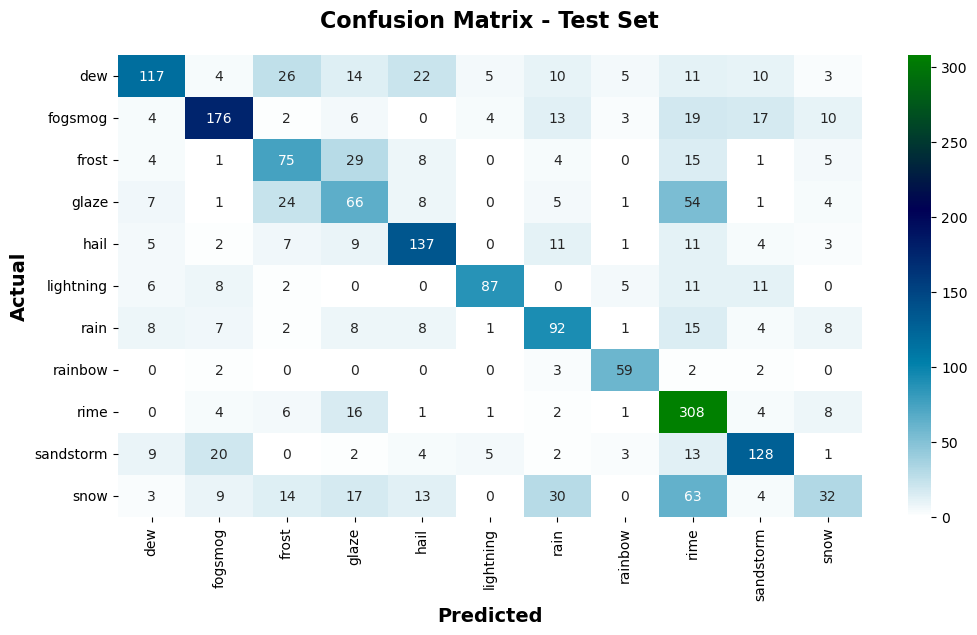

In [29]:
predictions = np.array(list(map(lambda x: np.argmax(x), model.predict(x_test))))
categories = label_encoder.classes_
CM = confusion_matrix(np.argmax(y_test, axis=1), predictions)
CMatrix = pd.DataFrame(CM, columns = categories, index = categories)
plt.figure(figsize=(12, 6)) 
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g',vmax = max(np.diagonal(CM)),cmap = 'ocean_r') 
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold') 
ax.set_xticklabels(ax.get_xticklabels(),rotation =90); 
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
plt.show()

In [30]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in vgg_model.layers:
    layer.trainable = False

x = Flatten()(vgg_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=x)

58889256/58889256 [==============================] - 0s 0us/step


In [31]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=4, verbose=1, factor=0.5, min_lr=0.00001)

#Data Generation
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train,y_train, batch_size=128),
                              epochs = 50, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 128
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
30/30 [==============================] - 14s 349ms/step - loss: 1.2418 - accuracy: 0.5775 - val_loss: 0.8278 - val_accuracy: 0.7149 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 9s 310ms/step - loss: 0.7709 - accuracy: 0.7340 - val_loss: 0.7150 - val_accuracy: 0.7544 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 9s 310ms/step - loss: 0.6878 - accuracy: 0.7693 - val_loss: 0.7236 - val_accuracy: 0.7544 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - 10s 347ms/step - loss: 0.6257 - accuracy: 0.7916 - val_loss: 0.7063 - val_accuracy: 0.7596 - lr: 0.0010
Epoch 5/50
30/30 [==============================] - 9s 309ms/step - loss: 0.6484 - accuracy: 0.7803 - val_loss: 0.9251 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 6/50
30/30 [==============================] - 9s 312ms/step - loss: 0.7028 - accuracy: 0.7674 - val_loss: 0.6588 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 7/50
30/30 [==============================] - 9s 313ms/step - 

In [32]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)
print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

Training: accuracy = 0.865435
Validation: accuracy = 0.780437
Test: accuracy = 0.803788


65/65 [==============================] - 1s 16ms/step


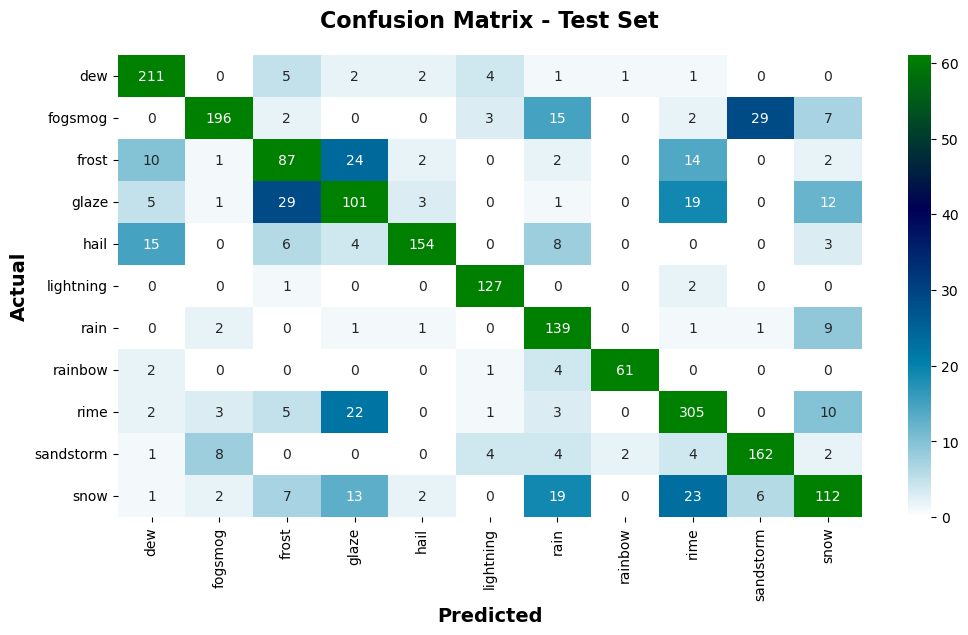

In [34]:
predictions = np.array(list(map(lambda x: np.argmax(x), model.predict(x_test))))
categories = label_encoder.classes_
CM = confusion_matrix(np.argmax(y_test, axis=1), predictions)
CMatrix = pd.DataFrame(CM, columns = categories, index = categories)
plt.figure(figsize=(12, 6)) 
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g',vmax = min(np.diagonal(CM)),cmap = 'ocean_r') 
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold') 
ax.set_xticklabels(ax.get_xticklabels(),rotation =90); 
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
plt.show()

In [35]:
y_pred = model.predict(x_test)
y_test_cat = np.argmax(y_test, axis=1)
y_pred_cat = np.argmax(y_pred, axis=1)
print(classification_report(y_test_cat, y_pred_cat))

65/65 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       227
           1       0.92      0.77      0.84       254
           2       0.61      0.61      0.61       142
           3       0.60      0.59      0.60       171
           4       0.94      0.81      0.87       190
           5       0.91      0.98      0.94       130
           6       0.71      0.90      0.79       154
           7       0.95      0.90      0.92        68
           8       0.82      0.87      0.84       351
           9       0.82      0.87      0.84       187
          10       0.71      0.61      0.65       185

    accuracy                           0.80      2059
   macro avg       0.80      0.80      0.80      2059
weighted avg       0.81      0.80      0.80      2059



In [5]:
Cold = ['glaze', 'rime', 'snow', 'frost']

new_lab = []
for lab in label:
    if lab in Cold:
        new_lab.append("snow")
    else:
        new_lab.append(lab)

In [6]:
WeatherData['class8'] = new_lab

In [7]:
Features = np.stack(WeatherData['image'].values)
Target = WeatherData['class8']

In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(Features, Target, test_size=0.3,random_state=666)
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [9]:
label_encoder = LabelEncoder()
y_train_o = label_encoder.fit_transform(y_train_o)
y_test_o = label_encoder.transform(y_test_o)
y_train = to_categorical(y_train_o, num_classes = 8)
y_test = to_categorical(y_test_o, num_classes = 8)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 999, stratify=y_train)

In [10]:
input_shape = (100, 100, 3)
num_classes = 8
x_train = x_train.reshape(x_train.shape[0], *(100, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 100, 3))

In [13]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in vgg_model.layers:
    layer.trainable = False

x = Flatten()(vgg_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=x)

In [14]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=4, verbose=1, factor=0.5, min_lr=0.00001)

#Data Generation
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train,y_train, batch_size=128),
                              epochs = 10, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 128
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
30/30 [==============================] - 12s 354ms/step - loss: 2.0320 - accuracy: 0.3708 - val_loss: 1.7962 - val_accuracy: 0.4162 - lr: 0.0010
Epoch 2/10
30/30 [==============================] - 11s 360ms/step - loss: 1.7970 - accuracy: 0.4098 - val_loss: 1.8002 - val_accuracy: 0.4162 - lr: 0.0010
Epoch 3/10
30/30 [==============================] - 10s 336ms/step - loss: 1.7737 - accuracy: 0.4187 - val_loss: 1.8117 - val_accuracy: 0.4142 - lr: 0.0010
Epoch 4/10
30/30 [==============================] - 10s 348ms/step - loss: 1.7821 - accuracy: 0.4152 - val_loss: 1.8055 - val_accuracy: 0.4142 - lr: 0.0010
Epoch 5/10
30/30 [==============================] - 10s 347ms/step - loss: 1.7636 - accuracy: 0.4146 - val_loss: 1.8159 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 6/10
30/30 [==============================] - 10s 341ms/step - loss: 1.7649 - accuracy: 0.4130 - val_loss: 1.8313 - val_accuracy: 0.3965 - lr: 0.0010
Epoch 7/10
30/30 [==============================] - 10s 339ms/st